# Introduction

In this markdown, we calculate the stratification of the probability density function (PDF) of the probability failure rates of equipment, to use in the Monte Carlo analysis of resiliency studies.

The aim of the stratification is to improve the accuracy of the results, minimizing the variance of the sample means from stratified samples.

The typical problem to solve is the following: 1. A return period for a given event intensity X is provided. 2. The random variable X has a CDF (cumulative density function) and a PDF (probability density function), that can be derived from the return period. 3. We have a second random variable Y, which is the probability of failure of an equipment, which is related to X (intensity of the event) by a fragility curve. Let’s define this relation as y=g(x) for all x in the range of X. 4. As the function g is strictly monotonic, we can use a simplified equation to calculate the derived probability distribution function of Y. This equation is:
\begin{align*}
f_Y(y) = f_X(h(y)) \cdot |\frac{dh(y)}{dy}|
\end{align*}
In this example, the minimum and maximum boundaries for the random variable X are equal respectively to 0.73 m and 1.5 m, as values outside of this range would provide zero probability of failure (x < 0.73 m), or unitary probability (x > 1.5).

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

The return period in this example is defined by the following equation:

\begin{align*}
x=0.145329158⋅\ln(r)+0.546101744
\end{align*}

where r is the return period, and x the water level

Let’s also make r
 explicit: $r=e^{\frac{x-0.546101744}{0.145329158}}$

Next we plot the given Return Period

\begin{align*}
x &= a⋅\ln(r)+b \\
a &= 0.145329158 \\
b &= 0.546101744
\end{align*}

Text(0.5, 1.0, 'Return Period')

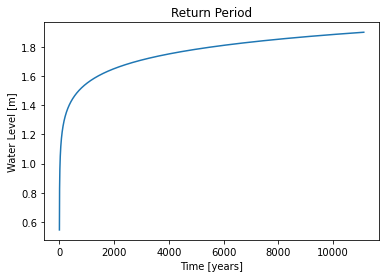

In [3]:
a = 0.145329158
b = 0.546101744

xmin = 0.546101744
xmax = 1.9
water_level = np.linspace(xmin,xmax,1000)

return_period_f = (lambda x: math.exp((x-b)/a))

plt.plot([return_period_f(x) for x in water_level],water_level)
plt.ylabel('Water Level [m]')
plt.xlabel('Time [years]')
plt.title('Return Period')
#plt.show()

The CDF from the return period is equal to:

\begin{align*}
F_X(x) = 1−\dfrac{1}{r} = 1−e^{\frac{0.546101744-x}{0.145329158}}
\end{align*}

The plot of the CDF is the following:

In [1]:
CDF_water_level_f = (lambda x: 1-1/return_period_f(x))

plt.plot(water_level, [CDF_water_level_f(x) for x in water_level])
plt.ylabel('CDF')
plt.xlabel('Water Level [m]')
plt.title('CDF of Hazard Intensity')
#plt.show()

NameError: name 'plt' is not defined

The PDF is calculated by derivating the CDF.

\begin{align*}
f_X(x) = \dfrac{dF_X}{dx}(x)=294.84274 \cdot e^{-\frac{x}{0.145329158}}
\end{align*}

We can now plot the PDF of the hazard event, characterized by the water level.

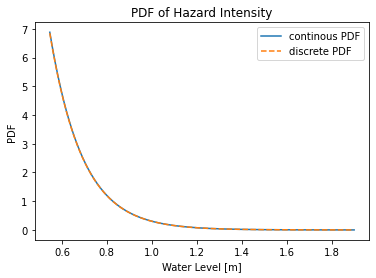

In [61]:
PDF_water_level_num = [294.84274*math.exp(-i/0.145329158) for i in water_level]

def derivative(y,x):
    dy_dx = []
    for i in range(len(x)-1):
        if np.diff(x)[i] != 0:
            dy_dx.append(np.diff(y)[i]/np.diff(x)[i])
        else:
            dy_dx.append(np.nan)
    return dy_dx

PDF_water_level_d = derivative([CDF_water_level_f(x) for x in water_level], water_level)

plt.plot(water_level, PDF_water_level_num, label='continous PDF')
plt.plot(water_level[:-1], PDF_water_level_d, '--', label='discrete PDF')

plt.ylabel('PDF')
plt.xlabel('Water Level [m]')
plt.title('PDF of Hazard Intensity')
plt.legend()
#plt.show()

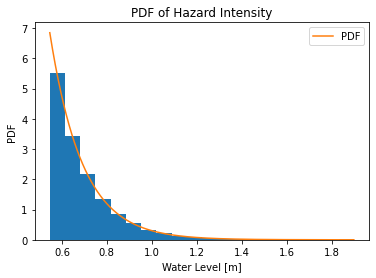

In [122]:
from pynverse import inversefunc
inv_CDF_water_level_f = inversefunc(CDF_water_level_f)

CDF_samples = np.linspace(CDF_water_level_f(xmin),CDF_water_level_f(xmax),1000)
water_level_resampled = [inv_CDF_water_level_f(cdf) for cdf in CDF_samples]

plt.hist(np.hstack(water_level_resampled), bins=20 ,density=True)
plt.plot(water_level[:-1], PDF_water_level_d, label='PDF')

plt.ylabel('PDF')
plt.xlabel('Water Level [m]')
plt.title('PDF of Hazard Intensity')
plt.legend()

The fragility curve is defined by the following system of equation:

\begin{align*}
f_c(x) = 
\begin{cases}
  0 &\forall x \in \mathopen]-\infty,0.722\mathclose[\\
  \dfrac{0.9}{0.7} \cdot x + \left( 0.1 - \dfrac{0.9}{0.7} \cdot 0.8 \right) &\forall x \in \mathopen[0.722, 1.5\mathclose] \\
  1 &\forall x \in \mathopen]1.5, +\infty\mathclose[
\end{cases}
\end{align*}

As it will be useful later, $\forall x \in \mathopen[0.722, 1.5\mathclose]$, the inverse function $x=h(y)$, is equal to:

\begin{align*}
x=h(y)= \dfrac{7}{9}(y-0.1)+0.8
\end{align*}


Here is the plot of the Fragility Curve, $\forall x \in \mathopen[0.722, 1.5\mathclose]$. Outside this interval, probability of failure can be easily calculated, as always equal to $0$ for all values of $x$ below 0.722 m, and equal to $1$ for all $x$ values above 1.5 m.

Text(0.5, 1.0, 'Fragility Curve')

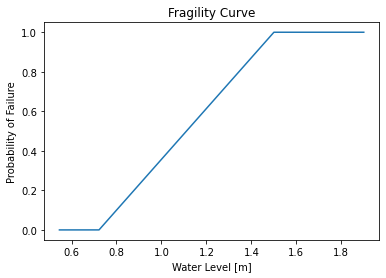

In [84]:
prob_failure = []
for i in water_level:
    if i < 0.722:
        prob_failure.append(0)
    elif i > 1.5:
        prob_failure.append(1)
    else:
        prob_failure.append(0.9/0.7*i+(0.1-0.9/0.7*0.8))
        
plt.plot(water_level, prob_failure)
plt.ylabel('Probability of Failure')
plt.xlabel('Water Level [m]')
plt.title('Fragility Curve')

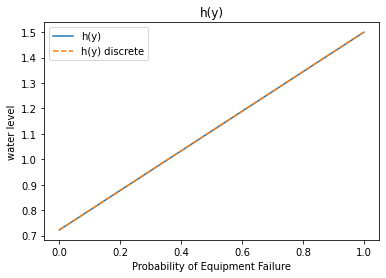

In [135]:
from pynverse import inversefunc
x_min = 0.722
x_max = 1.5

CDF_samples = np.linspace(CDF_water_level_f(x_min),CDF_water_level_f(x_max),1000)
water_level_resampled2 = [inv_CDF_water_level_f(cdf) for cdf in CDF_samples]

prob_failure_f = (lambda x: 0.9/0.7*x+(0.1-0.9/0.7*0.8))
inv_prob_failure_f = inversefunc(prob_failure_f)

dh_dy = derivative(water_level_resampled2, [prob_failure_f(x) for x in water_level_resampled2])
PDF_resampeled_d = derivative([CDF_water_level_f(x) for x in water_level_resampled2], water_level_resampled2)

PDF_prob_failure_d = [i1*abs(i2) for i1,i2 in zip(PDF_resampeled_d, dh_dy)]

plt.plot(prob_failure, [7/9*(i-0.1) + 0.8 for i in prob_failure], label='h(y)')
plt.plot(prob_failure, inv_prob_failure_f(prob_failure), '--' ,label='h(y) discrete')

plt.ylabel('water level')
plt.xlabel('Probability of Equipment Failure')
plt.title('h(y)')
plt.legend()

The derived distribution is calculated with the following equation:

$ f_Y(y)=f_X(h(y)) \cdot \left|\dfrac{dh}{dy}(y)\right| $, where $Y$ is the probability of failure of the equipment and $X$ the water level.

In the code below, we consider the PDF as conditional probability, with $X$ in the range $\mathopen[0.722, 1.5\mathclose]$
 only. Therefore, the PDF is scaled to have its integral in the interval $(0,1)$ equal to $1$.

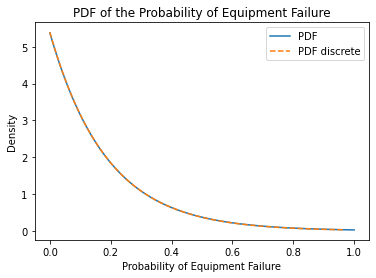

In [151]:
h_y = [7/9*(i-0.1) + 0.8 for i in prob_failure]
dh_dy = 7/9
f_X = [294.84274*math.exp(-i/0.145329158) for i in h_y]
f_Y = [i*dh_dy for i in f_X]

f_Y_scaled = [i/np.trapz(f_Y, x=prob_failure) for i in f_Y]

PDF_prob_failure_scaled_d = [i/np.trapz(PDF_prob_failure_d, x=[prob_failure_f(x) for x in water_level_resampled2][:-1]) for i in PDF_prob_failure_d]

plt.plot(prob_failure, f_Y_scaled, label='PDF')
plt.plot([prob_failure_f(x) for x in water_level_resampled2][:-1], PDF_prob_failure_scaled_d, '--' , label='PDF discrete')

plt.ylabel('Density')
plt.xlabel('Probability of Equipment Failure')
plt.title('PDF of the Probability of Equipment Failure')
plt.legend()

We now take samples from the PDF of the probability of equipment failure. To do this we use the inverse of the CDF, derived from the PDF

\begin{align*}
F_Y(y) = \int_0^y f_Y(t)\,dt = 0.18667998 \cdot \ln \left(\dfrac{−1.0047385}{y−1.0047385}\right)
\end{align*}


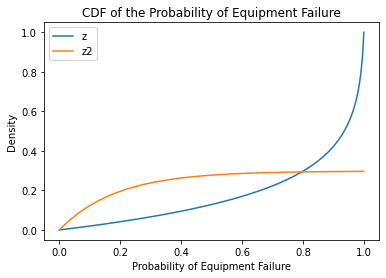

In [176]:
z = [0.18667998*math.log(-1.0047385/(i-1.0047385)) for i in prob_failure]

z2 = [-0.297639*math.exp(-5.35184*i)+0.297639 for i in prob_failure]



plt.plot(prob_failure, z, label='z')
plt.plot(prob_failure, z2, label='z2')
plt.ylabel('Density')
plt.xlabel('Probability of Equipment Failure')
plt.title('CDF of the Probability of Equipment Failure')
plt.legend()

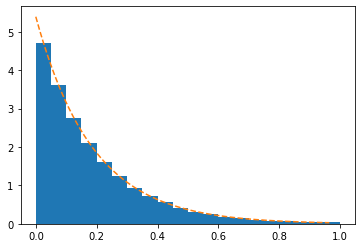

In [177]:
x = np.random.rand(10000)
#z = [0.18667998*math.log(-1.0047385/(i-1.0047385)) for i in x]
z = [prob_failure_f(x) for x in water_level_resampled2]

plt.hist(z, density=True, bins=20)
plt.plot([prob_failure_f(x) for x in water_level_resampled2][:-1], PDF_prob_failure_scaled_d, '--' , label='PDF discrete')

In [262]:
from sklearn.cluster import KMeans

x = np.array([prob_failure_f(x) for x in water_level_resampled2][:-1])
y = np.ones(len(x))

m = np.column_stack((x,y))

kmeans = KMeans(init="random", n_clusters=4,
                n_init=100, max_iter=300,random_state=1).fit(m)

maxs, mins, nh = [], [], []
for cluster in range(4):
    maxs.append(np.array(z)[np.where(kmeans.labels_==cluster)].max())
    mins.append(np.array(z)[np.where(kmeans.labels_==cluster)].min())
    nh.append(np.count_nonzero(kmeans.labels_ == cluster))

In [263]:
maxs

[0.5268847858557221,
 0.9643006254699485,
 0.12705547293023345,
 0.29224608043364675]

In [264]:
mins

[0.29313904683611713,
 0.5300384861757336,
 -0.0002857163853924316,
 0.12742383537178725]

In [265]:
nh

[150, 54, 497, 298]

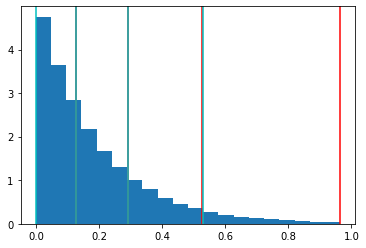

In [266]:
plt.hist([prob_failure_f(x) for x in water_level_resampled2][:-1], density=True, bins=20)

for b in maxs:
    plt.axvline(x = b, color = 'r')
for b in mins:
    plt.axvline(x = b, color = 'c')
